<a href="https://colab.research.google.com/github/saadatialirezam-create/glaucoma-detection/blob/main/01_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras import layers, models

## Load Splits

In [2]:
from google.colab import drive
drive.mount('/content/drive')

train = np.load("/content/drive/MyDrive/Glaucoma_data/splits/train_split.npz")
test  = np.load("/content/drive/MyDrive/Glaucoma_data/splits/test_split.npz")

X_train = train["X"]
y_train = train["y"]
X_test  = test["X"]
y_test  = test["y"]

print("Train:", X_train.shape, y_train.shape, X_train.dtype)
print("Test :", X_test.shape,  y_test.shape,  X_test.dtype)

if X_train.ndim == 3:
    X_train = X_train[..., None]
if X_test.ndim == 3:
    X_test = X_test[..., None]

print("After channel fix - Train:", X_train.shape, "Test:", X_test.shape)

Mounted at /content/drive
Train: (1898, 224, 224) (1898,) uint8
Test : (475, 224, 224) (475,) uint8
After channel fix - Train: (1898, 224, 224, 1) Test: (475, 224, 224, 1)


## Shuffle Data / Split Validation Set

In [3]:
SEED = 19
rng = np.random.default_rng(SEED)
idx = rng.permutation(len(y_train))
X_train = X_train[idx]
y_train = y_train[idx]

val_ratio = 0.2
val_size = int(len(y_train) * val_ratio)

X_val = X_train[:val_size]
y_val = y_train[:val_size]
X_tr  = X_train[val_size:]
y_tr  = y_train[val_size:]

print("Train split:", X_tr.shape, y_tr.shape)
print("Val split  :", X_val.shape, y_val.shape)

Train split: (1519, 224, 224, 1) (1519,)
Val split  : (379, 224, 224, 1) (379,)


## Build Framework



In [4]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def to_rgb_and_preprocess(x, y):
    x = tf.cast(x, tf.float32)
    x = tf.cond(tf.reduce_max(x) <= 1.0, lambda: x * 255.0, lambda: x)
    x = tf.image.grayscale_to_rgb(x)    # -> (224,224,3)
    x = preprocess_input(x)             # ResNet50 preprocessing
    return x, y

train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr)).shuffle(4096, seed=SEED).map(to_rgb_and_preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(to_rgb_and_preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(to_rgb_and_preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

## Build ResNet50

In [5]:
base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Compile & Fit

In [6]:
lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
)

# --- Fit ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

base.trainable = True

for layer in base.layers[:-30]:
    layer.trainable = False

print("Trainable layers in base:", sum(l.trainable for l in base.layers), "/", len(base.layers))

fine_tune_lr = 1e-5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 399ms/step - accuracy: 0.6547 - loss: 0.6576 - precision: 0.5300 - recall: 0.1933 - val_accuracy: 0.6596 - val_loss: 0.6583 - val_precision: 0.4595 - val_recall: 0.2764 - learning_rate: 1.0000e-04
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.6732 - loss: 0.6299 - precision: 0.5947 - recall: 0.3472 - val_accuracy: 0.6570 - val_loss: 0.6513 - val_precision: 0.4568 - val_recall: 0.3008 - learning_rate: 1.0000e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6842 - loss: 0.6290 - precision: 0.6279 - recall: 0.3812 - val_accuracy: 0.6755 - val_loss: 0.6371 - val_precision: 0.5000 - val_recall: 0.2927 - learning_rate: 1.0000e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.6995 - loss: 0.5928 - precision: 0.6341 - recall: 0.3986 - val_accuracy: 0.6781 - val_loss: 0.6290 - val_precision: 0.5067 - val_recall: 0.3089 - learning_rate: 1.0000e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/

## Classification Report

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

y_prob = model.predict(test_ds).ravel()

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 4) Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (rows=true, cols=pred):\n", cm)

tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal(0)", "Glaucoma(1)"]))

15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step
Confusion Matrix (rows=true, cols=pred):
 [[287  11]
 [ 95  82]]
TN=287, FP=11, FN=95, TP=82

Classification Report:
               precision    recall  f1-score   support

   Normal(0)       0.75      0.96      0.84       298
 Glaucoma(1)       0.88      0.46      0.61       177

    accuracy                           0.78       475
   macro avg       0.82      0.71      0.73       475
weighted avg       0.80      0.78      0.76       475



## Loss Plot

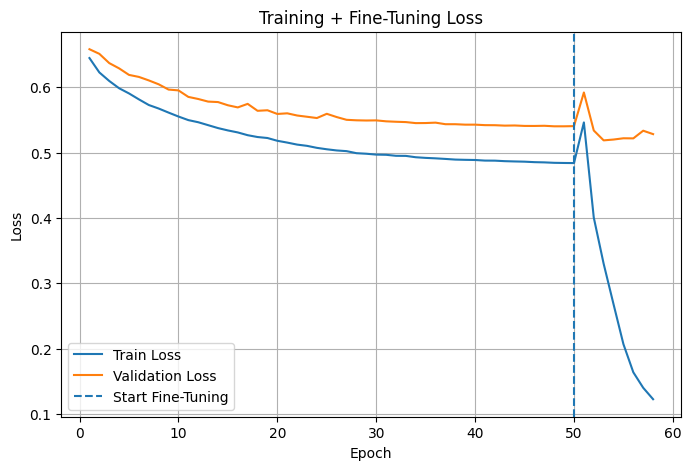

In [9]:
train_loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss   = history.history['val_loss'] + fine_tune_history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.axvline(x=len(history.history['loss']),
            linestyle='--',
            label='Start Fine-Tuning')

plt.title('Training + Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Confusion Matrix

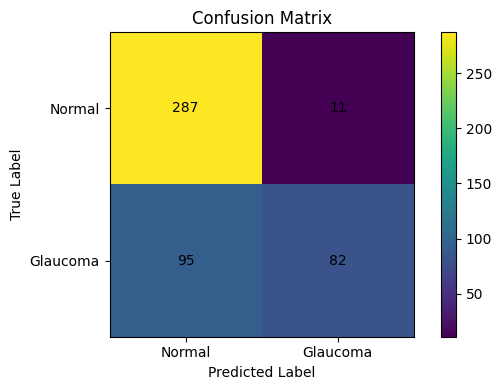

In [8]:
import matplotlib.pyplot as plt

classes = ["Normal", "Glaucoma"]

plt.figure(figsize=(6,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center", color="black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

## Evaluate on Test

In [10]:
test_metrics = model.evaluate(test_ds, verbose=1)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7684 - loss: 0.5330 - precision: 0.9112 - recall: 0.4624
Test metrics: {'loss': 0.5158430933952332, 'compile_metrics': 0.7768421173095703}


##Save outputs to Drive (for ensemble)

In [11]:
from pathlib import Path

SAVE_DIR = Path("/content/drive/MyDrive/Glaucoma_data/preds")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

y_prob = model.predict(test_ds).ravel()

y_pred = (y_prob >= 0.5).astype(np.int64)

np.save(SAVE_DIR / "y_true.npy", y_true)
np.save(SAVE_DIR / "resnet50_prob.npy", y_prob)
np.save(SAVE_DIR / "resnet50_pred.npy", y_pred)

print("Saved to:", SAVE_DIR)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Saved to: /content/drive/MyDrive/Glaucoma_data/preds
